In [2]:
import sys
import os

# Add the parent directory to Python path
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from utils.load_meso_session import MesoscopeSession


In [3]:

from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from one.api import ONE

one = ONE()

# First, let's prepare the data in the right format
session = MesoscopeSession.from_csv(one, '../good_mesoscope_sessions_final.csv', 0)
activity_matrix, timestamps = session.get_activity_matrix(time_window=300)

c:\Users\Gugu\Desktop\UCL\Thesis\Experiments\IBL_Mesoscope\ibl_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
activity_matrix, timestamps = session.get_activity_matrix(time_window=300)
print(activity_matrix.shape)
activity_matrix[0]


(1462, 7673)


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [5]:
activity_matrix[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [9]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

class SimpleNeuralTransformer(nn.Module):
    """Simple transformer for neural time series prediction"""
    
    def __init__(self, input_size=1, d_model=64, nhead=4, num_layers=2, 
                 context_length=20, prediction_length=5, dropout=0.1):
        super().__init__()
        
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.d_model = d_model
        
        # Input projection
        self.input_projection = nn.Linear(input_size, d_model)
        
        # Positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(context_length + prediction_length, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, input_size)
        
        # Causal mask for autoregressive generation
        self.register_buffer('causal_mask', self._generate_causal_mask(context_length + prediction_length))
    
    def _generate_causal_mask(self, size):
        """Generate causal mask for transformer"""
        mask = torch.triu(torch.ones(size, size) * float('-inf'), diagonal=1)
        return mask
    
    def forward(self, x, target=None):
        """
        Args:
            x: [batch_size, context_length, input_size] - past values
            target: [batch_size, prediction_length, input_size] - future values (for training)
        Returns:
            predictions: [batch_size, prediction_length, input_size]
        """
        batch_size = x.size(0)
        
        if target is not None:
            # Training mode: concatenate past and future
            seq = torch.cat([x, target], dim=1)  # [batch, context+pred, input_size]
            seq_len = seq.size(1)
        else:
            # Inference mode: only past values
            seq = x
            seq_len = x.size(1)
        
        # Project to model dimension
        seq_proj = self.input_projection(seq)  # [batch, seq_len, d_model]
        
        # Add positional encoding
        pos_enc = self.pos_encoding[:seq_len].unsqueeze(0).expand(batch_size, -1, -1)
        seq_proj = seq_proj + pos_enc
        
        # Apply transformer with causal mask
        mask = self.causal_mask[:seq_len, :seq_len]
        output = self.transformer(seq_proj, mask=mask)  # [batch, seq_len, d_model]
        
        # Project back to input dimension
        predictions = self.output_projection(output)  # [batch, seq_len, input_size]
        
        if target is not None:
            # Return only the future predictions
            return predictions[:, self.context_length:, :]
        else:
            return predictions
    
    def predict(self, x):
        """Generate predictions autoregressively"""
        self.eval()
        with torch.no_grad():
            batch_size = x.size(0)
            device = x.device
            
            # Start with the input sequence
            current_seq = x.clone()  # [batch, context_length, input_size]
            
            # Generate predictions one step at a time
            predictions = []
            
            for _ in range(self.prediction_length):
                # Get prediction for next timestep
                output = self.forward(current_seq)  # [batch, seq_len, input_size]
                next_pred = output[:, -1:, :]  # [batch, 1, input_size] - last timestep
                
                predictions.append(next_pred)
                
                # Add prediction to sequence for next iteration
                current_seq = torch.cat([current_seq[:, 1:, :], next_pred], dim=1)
            
            # Concatenate all predictions
            return torch.cat(predictions, dim=1)  # [batch, prediction_length, input_size]

class NeuralDataset(Dataset):
    """Dataset for neural time series"""
    
    def __init__(self, data, context_length, prediction_length, normalize=True):
        """
        Args:
            data: [n_neurons, n_timepoints] numpy array
            context_length: number of past time points
            prediction_length: number of future time points to predict
            normalize: whether to normalize the data
        """
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.window_size = context_length + prediction_length
        
        # Normalize data per neuron if requested
        if normalize:
            self.scaler = StandardScaler()
            data_norm = self.scaler.fit_transform(data.T).T  # Normalize each neuron
            self.data = torch.FloatTensor(data_norm)
        else:
            self.data = torch.FloatTensor(data)
            self.scaler = None
        
        self.n_neurons, self.n_timepoints = data.shape
        
        # Calculate valid starting positions for windows
        self.valid_starts = max(1, self.n_timepoints - self.window_size + 1)
        
    def __len__(self):
        return self.n_neurons * self.valid_starts
    
    def __getitem__(self, idx):
        # Determine which neuron and which time window
        neuron_idx = idx // self.valid_starts
        window_start = idx % self.valid_starts
        
        # Extract the window
        window_end = window_start + self.window_size
        window_data = self.data[neuron_idx, window_start:window_end]
        
        # Split into past and future
        past_values = window_data[:self.context_length].unsqueeze(-1)  # [context_length, 1]
        future_values = window_data[self.context_length:].unsqueeze(-1)  # [prediction_length, 1]
        
        return {
            'past_values': past_values,
            'future_values': future_values,
            'neuron_id': neuron_idx
        }

def train_neural_transformer(model, train_loader, val_loader, epochs=10, lr=1e-3, device='cuda'):
    """Train the neural transformer"""
    
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_batches = 0
        
        for batch in train_loader:
            past_values = batch['past_values'].to(device)
            future_values = batch['future_values'].to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(past_values, future_values)
            loss = criterion(predictions, future_values)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
        
        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)
        
        # Validation
        if val_loader is not None:
            model.eval()
            val_loss = 0
            val_batches = 0
            
            with torch.no_grad():
                for batch in val_loader:
                    past_values = batch['past_values'].to(device)
                    future_values = batch['future_values'].to(device)
                    
                    predictions = model(past_values, future_values)
                    loss = criterion(predictions, future_values)
                    
                    val_loss += loss.item()
                    val_batches += 1
            
            avg_val_loss = val_loss / val_batches
            val_losses.append(avg_val_loss)
            
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
        else:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}')
    
    return train_losses, val_losses

def evaluate_model(model, test_loader, device='cuda'):
    """Evaluate the model and return predictions vs targets"""
    
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in test_loader:
            past_values = batch['past_values'].to(device)
            future_values = batch['future_values'].to(device)
            
            # Generate predictions
            predictions = model.predict(past_values)
            
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(future_values.cpu().numpy())
    
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    
    return predictions, targets

def visualize_results(predictions, targets, n_examples=4):
    """Visualize predictions vs targets"""
    
    # Remove feature dimension
    predictions = predictions.squeeze(-1)  # [batch, pred_len]
    targets = targets.squeeze(-1)  # [batch, pred_len]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    for i in range(min(n_examples, len(predictions))):
        ax = axes[i//2, i%2]
        
        time_steps = range(len(targets[i]))
        
        ax.plot(time_steps, targets[i], 'g-', label='Target', linewidth=2)
        ax.plot(time_steps, predictions[i], 'r--', label='Prediction', linewidth=2)
        
        ax.set_title(f'Neuron Example {i+1}')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Activity')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics
    mse = np.mean((predictions - targets) ** 2)
    mae = np.mean(np.abs(predictions - targets))
    
    # Calculate correlation per example
    correlations = []
    for i in range(len(predictions)):
        if np.std(targets[i]) > 0 and np.std(predictions[i]) > 0:
            corr = np.corrcoef(predictions[i], targets[i])[0, 1]
            if not np.isnan(corr):
                correlations.append(corr)
    
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    if correlations:
        print(f"Mean Correlation: {np.mean(correlations):.4f} ± {np.std(correlations):.4f}")

def run_simple_neural_transformer(activity_matrix, max_neurons=50, context_length=20, 
                                prediction_length=5, epochs=10, batch_size=32):
    """
    Run simple transformer on neural data
    
    Args:
        activity_matrix: [time_points, neurons] numpy array
        max_neurons: maximum number of neurons to use
        context_length: number of past time points to use
        prediction_length: number of future time points to predict
        epochs: number of training epochs
        batch_size: batch size
    """
    print(f"Original data shape: {activity_matrix.shape}")
    
    # Use subset of neurons
    if activity_matrix.shape[1] > max_neurons:
        selected_neurons = np.random.choice(activity_matrix.shape[1], max_neurons, replace=False)
        activity_subset = activity_matrix[:, selected_neurons].T  # [neurons, time_points]
        print(f"Using {max_neurons} neurons out of {activity_matrix.shape[1]}")
    else:
        activity_subset = activity_matrix.T  # [neurons, time_points]
        max_neurons = activity_matrix.shape[1]
        print(f"Using all {max_neurons} neurons")
    
    print(f"Data shape after transpose: {activity_subset.shape}")
    
    # Split data temporally
    n_neurons, n_timepoints = activity_subset.shape
    train_split = int(0.7 * n_timepoints)
    val_split = int(0.85 * n_timepoints)
    
    train_data = activity_subset[:, :train_split]
    val_data = activity_subset[:, train_split:val_split]
    test_data = activity_subset[:, val_split:]
    
    print(f"Train data: {train_data.shape}")
    print(f"Val data: {val_data.shape}")
    print(f"Test data: {test_data.shape}")
    
    # Create datasets
    train_dataset = NeuralDataset(train_data, context_length, prediction_length)
    val_dataset = NeuralDataset(val_data, context_length, prediction_length)
    test_dataset = NeuralDataset(test_data, context_length, prediction_length)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Val dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
    
    # Create model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SimpleNeuralTransformer(
        input_size=1,
        d_model=64,
        nhead=8,
        num_layers=3,
        context_length=context_length,
        prediction_length=prediction_length,
        dropout=0.1
    )
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Using device: {device}")
    
    # Train model
    print("Starting training...")
    train_losses, val_losses = train_neural_transformer(
        model, train_loader, val_loader, epochs=epochs, device=device
    )
    
    # Evaluate model
    print("Evaluating model...")
    predictions, targets = evaluate_model(model, test_loader, device=device)
    
    # Visualize results
    print("Visualizing results...")
    visualize_results(predictions, targets)
    
    return model, predictions, targets, train_losses, val_losses

# Example usage
print("Simple Neural Transformer ready!")
print("Usage:")
print("model, predictions, targets, train_losses, val_losses = run_simple_neural_transformer(activity_matrix)")
print("This approach uses a standard transformer architecture designed specifically for neural time series.")

Simple Neural Transformer ready!
Usage:
model, predictions, targets, train_losses, val_losses = run_simple_neural_transformer(activity_matrix)
This approach uses a standard transformer architecture designed specifically for neural time series.


Original data shape: (1462, 7673)
Using 100 neurons out of 7673
Data shape after transpose: (100, 1462)
Train data: (100, 1023)
Val data: (100, 219)
Test data: (100, 220)
Train dataset size: 101400
Val dataset size: 21000
Test dataset size: 21100
Model parameters: 150,785
Using device: cuda
Starting training...
Epoch 1/2, Train Loss: 0.042349, Val Loss: 0.008992
Epoch 2/2, Train Loss: 0.011883, Val Loss: 0.001497
Evaluating model...
Visualizing results...


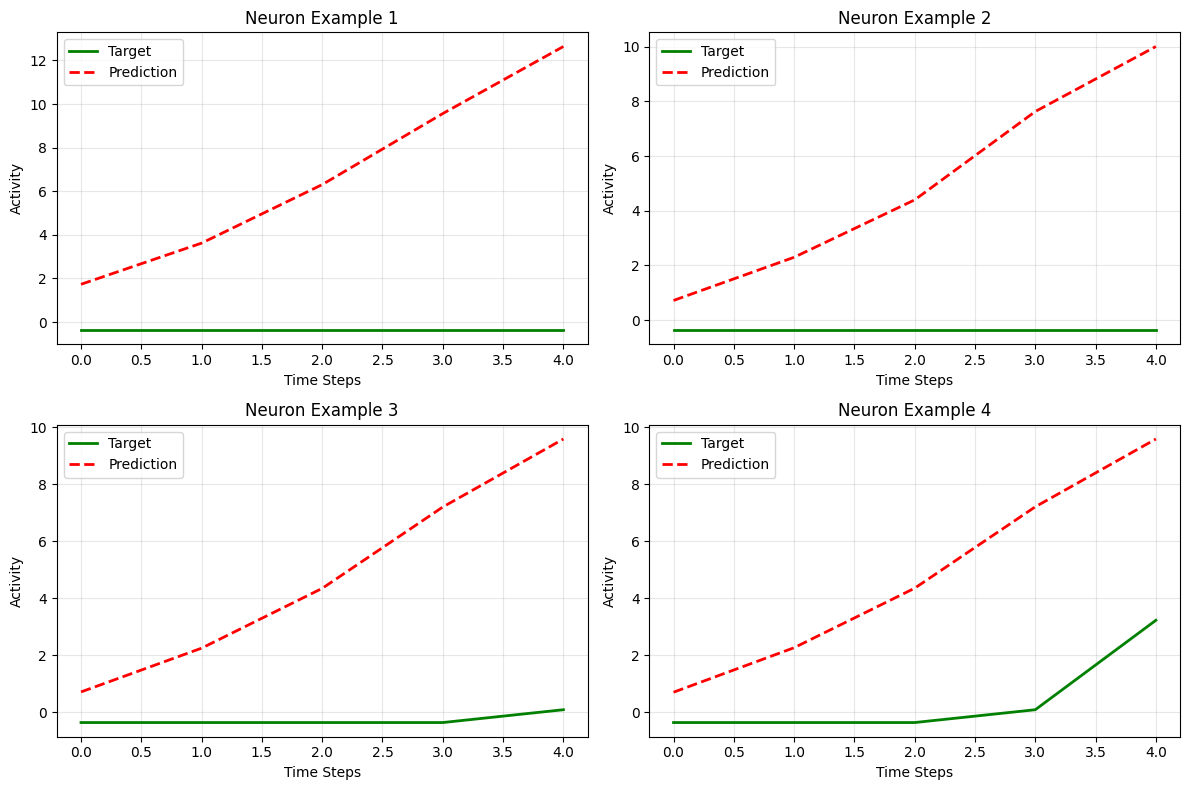

c:\Users\Gugu\Desktop\UCL\Thesis\Experiments\IBL_Neuropixels\ibl_env\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  literature, where it is used as one of many windowing functions for
c:\Users\Gugu\Desktop\UCL\Thesis\Experiments\IBL_Neuropixels\ibl_env\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  smoothing values.  It is also known as an apodization (which means


MSE: 48.018005
MAE: 5.740747
Mean Correlation: 0.0014 ± 0.5065


In [34]:
# Load your session data
activity_matrix, timestamps = session.get_activity_matrix(time_window=300)

model, predictions, targets, train_losses, val_losses = run_simple_neural_transformer(
    activity_matrix,
    max_neurons=100,
    context_length=5,
    prediction_length=5,
    epochs=2
)

In [39]:
predictions[0]

array([[ 1.7327135],
       [ 3.622089 ],
       [ 6.305689 ],
       [ 9.565838 ],
       [12.641681 ]], dtype=float32)

In [40]:
targets[0]

array([[-0.36645493],
       [-0.36645493],
       [-0.36645493],
       [-0.36645493],
       [-0.36645493]], dtype=float32)

In [11]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def preprocess_fluorescence_data(activity_matrix, lower_percentile=20, upper_percentile=99, 
                               method='percentile_clip', per_neuron=True):
    """
    Preprocess fluorescence activity data with robust normalization
    
    Args:
        activity_matrix: [time_points, neurons] numpy array of raw fluorescence values
        lower_percentile: Lower percentile for clipping (default 20th)
        upper_percentile: Upper percentile for clipping (default 99th)
        method: 'percentile_clip' or 'z_score_robust'
        per_neuron: Whether to normalize each neuron individually (True) or globally (False)
    
    Returns:
        normalized_data: Normalized activity matrix [time_points, neurons]
        scaler_info: Dictionary with scaling parameters for inverse transform if needed
    """
    print(f"Original data range: [{activity_matrix.min():.2f}, {activity_matrix.max():.2f}]")
    
    if method == 'percentile_clip':
        if per_neuron:
            # Normalize each neuron individually
            normalized_data = np.zeros_like(activity_matrix)
            lower_bounds = []
            upper_bounds = []
            
            for neuron_idx in range(activity_matrix.shape[1]):
                neuron_data = activity_matrix[:, neuron_idx]
                
                # Calculate percentiles for this neuron
                lower_bound = np.percentile(neuron_data, lower_percentile)
                upper_bound = np.percentile(neuron_data, upper_percentile)
                
                # Clip and normalize to [0, 1]
                clipped = np.clip(neuron_data, lower_bound, upper_bound)
                if upper_bound > lower_bound:
                    normalized = (clipped - lower_bound) / (upper_bound - lower_bound)
                else:
                    normalized = np.zeros_like(clipped)  # Handle case where all values are the same
                
                normalized_data[:, neuron_idx] = normalized
                lower_bounds.append(lower_bound)
                upper_bounds.append(upper_bound)
            
            scaler_info = {
                'method': 'percentile_clip_per_neuron',
                'lower_bounds': np.array(lower_bounds),
                'upper_bounds': np.array(upper_bounds),
                'lower_percentile': lower_percentile,
                'upper_percentile': upper_percentile
            }
            
        else:
            # Global normalization across all neurons
            lower_bound = np.percentile(activity_matrix, lower_percentile)
            upper_bound = np.percentile(activity_matrix, upper_percentile)
            
            # Clip and normalize
            clipped = np.clip(activity_matrix, lower_bound, upper_bound)
            normalized_data = (clipped - lower_bound) / (upper_bound - lower_bound)
            
            scaler_info = {
                'method': 'percentile_clip_global',
                'lower_bound': lower_bound,
                'upper_bound': upper_bound,
                'lower_percentile': lower_percentile,
                'upper_percentile': upper_percentile
            }
    
    elif method == 'z_score_robust':
        if per_neuron:
            # Robust z-score per neuron using median and MAD
            normalized_data = np.zeros_like(activity_matrix)
            medians = []
            mads = []
            
            for neuron_idx in range(activity_matrix.shape[1]):
                neuron_data = activity_matrix[:, neuron_idx]
                
                # Calculate robust statistics
                median = np.median(neuron_data)
                mad = np.median(np.abs(neuron_data - median))
                
                # Robust z-score (using MAD instead of std)
                if mad > 0:
                    normalized = (neuron_data - median) / (1.4826 * mad)  # 1.4826 makes MAD consistent with std for normal dist
                else:
                    normalized = np.zeros_like(neuron_data)
                
                # Clip extreme values and rescale to [0, 1]
                clipped = np.clip(normalized, -3, 3)  # Clip at ±3 robust standard deviations
                normalized_data[:, neuron_idx] = (clipped + 3) / 6  # Scale to [0, 1]
                
                medians.append(median)
                mads.append(mad)
            
            scaler_info = {
                'method': 'z_score_robust_per_neuron',
                'medians': np.array(medians),
                'mads': np.array(mads)
            }
        else:
            # Global robust z-score
            median = np.median(activity_matrix)
            mad = np.median(np.abs(activity_matrix - median))
            
            if mad > 0:
                normalized = (activity_matrix - median) / (1.4826 * mad)
            else:
                normalized = np.zeros_like(activity_matrix)
            
            # Clip and rescale
            clipped = np.clip(normalized, -3, 3)
            normalized_data = (clipped + 3) / 6
            
            scaler_info = {
                'method': 'z_score_robust_global',
                'median': median,
                'mad': mad
            }
    
    print(f"Normalized data range: [{normalized_data.min():.4f}, {normalized_data.max():.4f}]")
    print(f"Normalization method: {scaler_info['method']}")
    
    # Show some statistics
    if per_neuron:
        print(f"Per-neuron normalization applied to {activity_matrix.shape[1]} neurons")
        print(f"Mean activity per neuron - before: {np.mean(activity_matrix, axis=0)[:5]}")
        print(f"Mean activity per neuron - after: {np.mean(normalized_data, axis=0)[:5]}")
    else:
        print(f"Global normalization applied")
        print(f"Overall mean - before: {np.mean(activity_matrix):.2f}, after: {np.mean(normalized_data):.4f}")
    
    return normalized_data, scaler_info

def plot_normalization_comparison(original_data, normalized_data, n_neurons=4):
    """Plot comparison of original vs normalized data for a few neurons"""
    
    fig, axes = plt.subplots(2, n_neurons, figsize=(15, 8))
    
    selected_neurons = np.random.choice(original_data.shape[1], min(n_neurons, original_data.shape[1]), replace=False)
    
    for i, neuron_idx in enumerate(selected_neurons):
        # Original data
        axes[0, i].plot(original_data[:200, neuron_idx], 'b-', alpha=0.7)
        axes[0, i].set_title(f'Original - Neuron {neuron_idx}')
        axes[0, i].set_ylabel('Fluorescence')
        axes[0, i].grid(True, alpha=0.3)
        
        # Normalized data
        axes[1, i].plot(normalized_data[:200, neuron_idx], 'r-', alpha=0.7)
        axes[1, i].set_title(f'Normalized - Neuron {neuron_idx}')
        axes[1, i].set_ylabel('Normalized Activity')
        axes[1, i].set_xlabel('Time Steps')
        axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show distribution comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Original distribution
    axes[0].hist(original_data.flatten(), bins=100, alpha=0.7, density=True)
    axes[0].set_xlabel('Original Fluorescence Values')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Original Data Distribution')
    axes[0].set_yscale('log')
    
    # Normalized distribution
    axes[1].hist(normalized_data.flatten(), bins=100, alpha=0.7, density=True)
    axes[1].set_xlabel('Normalized Values')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Normalized Data Distribution')
    
    plt.tight_layout()
    plt.show()
    """Simple transformer for neural time series prediction"""
    
    def __init__(self, input_size=1, d_model=64, nhead=4, num_layers=2, 
                 context_length=20, prediction_length=5, dropout=0.1):
        super().__init__()
        
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.d_model = d_model
        
        # Input projection
        self.input_projection = nn.Linear(input_size, d_model)
        
        # Positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(context_length + prediction_length, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, input_size)
        
        # Causal mask for autoregressive generation
        self.register_buffer('causal_mask', self._generate_causal_mask(context_length + prediction_length))
    
    def _generate_causal_mask(self, size):
        """Generate causal mask for transformer"""
        mask = torch.triu(torch.ones(size, size) * float('-inf'), diagonal=1)
        return mask
    
    def forward(self, x, target=None):
        """
        Args:
            x: [batch_size, context_length, input_size] - past values
            target: [batch_size, prediction_length, input_size] - future values (for training)
        Returns:
            predictions: [batch_size, prediction_length, input_size]
        """
        batch_size = x.size(0)
        
        if target is not None:
            # Training mode: concatenate past and future
            seq = torch.cat([x, target], dim=1)  # [batch, context+pred, input_size]
            seq_len = seq.size(1)
        else:
            # Inference mode: only past values
            seq = x
            seq_len = x.size(1)
        
        # Project to model dimension
        seq_proj = self.input_projection(seq)  # [batch, seq_len, d_model]
        
        # Add positional encoding
        pos_enc = self.pos_encoding[:seq_len].unsqueeze(0).expand(batch_size, -1, -1)
        seq_proj = seq_proj + pos_enc
        
        # Apply transformer with causal mask
        mask = self.causal_mask[:seq_len, :seq_len]
        output = self.transformer(seq_proj, mask=mask)  # [batch, seq_len, d_model]
        
        # Project back to input dimension
        predictions = self.output_projection(output)  # [batch, seq_len, input_size]
        
        if target is not None:
            # Return only the future predictions
            return predictions[:, self.context_length:, :]
        else:
            return predictions
    
    def predict(self, x):
        """Generate predictions autoregressively"""
        self.eval()
        with torch.no_grad():
            batch_size = x.size(0)
            device = x.device
            
            # Start with the input sequence
            current_seq = x.clone()  # [batch, context_length, input_size]
            
            # Generate predictions one step at a time
            predictions = []
            
            for _ in range(self.prediction_length):
                # Get prediction for next timestep
                output = self.forward(current_seq)  # [batch, seq_len, input_size]
                next_pred = output[:, -1:, :]  # [batch, 1, input_size] - last timestep
                
                predictions.append(next_pred)
                
                # Add prediction to sequence for next iteration
                current_seq = torch.cat([current_seq[:, 1:, :], next_pred], dim=1)
            
            # Concatenate all predictions
            return torch.cat(predictions, dim=1)  # [batch, prediction_length, input_size]

class NeuralDataset(Dataset):
    """Dataset for neural time series"""
    
    def __init__(self, data, context_length, prediction_length, normalize=False):
        """
        Args:
            data: [n_neurons, n_timepoints] numpy array
            context_length: number of past time points
            prediction_length: number of future time points to predict
            normalize: whether to apply additional z-score normalization (data should already be preprocessed)
        """
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.window_size = context_length + prediction_length
        
        # Apply additional normalization if requested (usually not needed after preprocessing)
        if normalize:
            self.scaler = StandardScaler()
            data_norm = self.scaler.fit_transform(data.T).T  # Normalize each neuron
            self.data = torch.FloatTensor(data_norm)
        else:
            self.data = torch.FloatTensor(data)
            self.scaler = None
        
        self.n_neurons, self.n_timepoints = data.shape
        
        # Calculate valid starting positions for windows
        self.valid_starts = max(1, self.n_timepoints - self.window_size + 1)
        
    def __len__(self):
        return self.n_neurons * self.valid_starts
    
    def __getitem__(self, idx):
        # Determine which neuron and which time window
        neuron_idx = idx // self.valid_starts
        window_start = idx % self.valid_starts
        
        # Extract the window
        window_end = window_start + self.window_size
        window_data = self.data[neuron_idx, window_start:window_end]
        
        # Split into past and future
        past_values = window_data[:self.context_length].unsqueeze(-1)  # [context_length, 1]
        future_values = window_data[self.context_length:].unsqueeze(-1)  # [prediction_length, 1]
        
        return {
            'past_values': past_values,
            'future_values': future_values,
            'neuron_id': neuron_idx
        }

def train_neural_transformer(model, train_loader, val_loader, epochs=10, lr=1e-3, device='cuda'):
    """Train the neural transformer"""
    
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_batches = 0
        
        for batch in train_loader:
            past_values = batch['past_values'].to(device)
            future_values = batch['future_values'].to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(past_values, future_values)
            loss = criterion(predictions, future_values)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
        
        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)
        
        # Validation
        if val_loader is not None:
            model.eval()
            val_loss = 0
            val_batches = 0
            
            with torch.no_grad():
                for batch in val_loader:
                    past_values = batch['past_values'].to(device)
                    future_values = batch['future_values'].to(device)
                    
                    predictions = model(past_values, future_values)
                    loss = criterion(predictions, future_values)
                    
                    val_loss += loss.item()
                    val_batches += 1
            
            avg_val_loss = val_loss / val_batches
            val_losses.append(avg_val_loss)
            
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
        else:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}')
    
    return train_losses, val_losses

def evaluate_model(model, test_loader, device='cuda'):
    """Evaluate the model and return predictions vs targets"""
    
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in test_loader:
            past_values = batch['past_values'].to(device)
            future_values = batch['future_values'].to(device)
            
            # Generate predictions
            predictions = model.predict(past_values)
            
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(future_values.cpu().numpy())
    
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    
    return predictions, targets

def visualize_results(predictions, targets, n_examples=4):
    """Visualize predictions vs targets"""
    
    # Remove feature dimension
    predictions = predictions.squeeze(-1)  # [batch, pred_len]
    targets = targets.squeeze(-1)  # [batch, pred_len]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    for i in range(min(n_examples, len(predictions))):
        ax = axes[i//2, i%2]
        
        time_steps = range(len(targets[i]))
        
        ax.plot(time_steps, targets[i], 'g-', label='Target', linewidth=2)
        ax.plot(time_steps, predictions[i], 'r--', label='Prediction', linewidth=2)
        
        ax.set_title(f'Neuron Example {i+1}')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Activity')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics
    mse = np.mean((predictions - targets) ** 2)
    mae = np.mean(np.abs(predictions - targets))
    
    # Calculate correlation per example
    correlations = []
    for i in range(len(predictions)):
        if np.std(targets[i]) > 0 and np.std(predictions[i]) > 0:
            corr = np.corrcoef(predictions[i], targets[i])[0, 1]
            if not np.isnan(corr):
                correlations.append(corr)
    
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    if correlations:
        print(f"Mean Correlation: {np.mean(correlations):.4f} ± {np.std(correlations):.4f}")

def run_simple_neural_transformer(activity_matrix, max_neurons=50, context_length=20, 
                                prediction_length=5, epochs=10, batch_size=32,
                                normalize_method='percentile_clip', lower_percentile=20, 
                                upper_percentile=99, per_neuron=True, show_normalization_plots=True):
    """
    Run simple transformer on neural data with preprocessing
    
    Args:
        activity_matrix: [time_points, neurons] numpy array
        max_neurons: maximum number of neurons to use
        context_length: number of past time points to use
        prediction_length: number of future time points to predict
        epochs: number of training epochs
        batch_size: batch size
        normalize_method: 'percentile_clip' or 'z_score_robust'
        lower_percentile: Lower percentile for clipping (default 20th)
        upper_percentile: Upper percentile for clipping (default 99th) 
        per_neuron: Whether to normalize each neuron individually
        show_normalization_plots: Whether to show before/after normalization plots
    """
    print(f"Original data shape: {activity_matrix.shape}")
    
    # Preprocess the data with robust normalization
    print("\nPreprocessing fluorescence data...")
    normalized_activity, scaler_info = preprocess_fluorescence_data(
        activity_matrix, 
        lower_percentile=lower_percentile,
        upper_percentile=upper_percentile,
        method=normalize_method,
        per_neuron=per_neuron
    )
    
    # Show normalization comparison if requested
    if show_normalization_plots:
        plot_normalization_comparison(activity_matrix, normalized_activity)
    
    # Use subset of neurons
    if normalized_activity.shape[1] > max_neurons:
        selected_neurons = np.random.choice(normalized_activity.shape[1], max_neurons, replace=False)
        activity_subset = normalized_activity[:, selected_neurons].T  # [neurons, time_points]
        print(f"\nUsing {max_neurons} neurons out of {normalized_activity.shape[1]}")
    else:
        activity_subset = normalized_activity.T  # [neurons, time_points]
        max_neurons = normalized_activity.shape[1]
        print(f"\nUsing all {max_neurons} neurons")
    
    print(f"Data shape after transpose: {activity_subset.shape}")
    
    # Split data temporally
    n_neurons, n_timepoints = activity_subset.shape
    train_split = int(0.7 * n_timepoints)
    val_split = int(0.85 * n_timepoints)
    
    train_data = activity_subset[:, :train_split]
    val_data = activity_subset[:, train_split:val_split]
    test_data = activity_subset[:, val_split:]
    
    print(f"Train data: {train_data.shape}")
    print(f"Val data: {val_data.shape}")
    print(f"Test data: {test_data.shape}")
    
    # Create datasets (no additional normalization since we already preprocessed)
    train_dataset = NeuralDataset(train_data, context_length, prediction_length, normalize=False)
    val_dataset = NeuralDataset(val_data, context_length, prediction_length, normalize=False)
    test_dataset = NeuralDataset(test_data, context_length, prediction_length, normalize=False)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Val dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
    
    # Create model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SimpleNeuralTransformer(
        input_size=1,
        d_model=64,
        nhead=8,
        num_layers=3,
        context_length=context_length,
        prediction_length=prediction_length,
        dropout=0.1
    )
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Using device: {device}")
    
    # Train model
    print("\nStarting training...")
    train_losses, val_losses = train_neural_transformer(
        model, train_loader, val_loader, epochs=epochs, device=device
    )
    
    # Evaluate model
    print("Evaluating model...")
    predictions, targets = evaluate_model(model, test_loader, device=device)
    
    # Visualize results
    print("Visualizing results...")
    visualize_results(predictions, targets)
    
    return model, predictions, targets, train_losses, val_losses, scaler_info

session = MesoscopeSession.from_csv(one, '../good_mesoscope_sessions_final.csv', 0)
activity_matrix, timestamps = session.get_activity_matrix(time_window=300)

# Run with preprocessing
model, predictions, targets, train_losses, val_losses, scaler_info = run_simple_neural_transformer(
    activity_matrix,
    max_neurons=500,
    normalize_method='percentile_clip',  # Clips to 20th-99th percentiles
    lower_percentile=20,
    upper_percentile=99, 
    per_neuron=True,  # Normalize each neuron individually
    show_normalization_plots=False,  # Show before/after plots
    epochs=2
)

Original data shape: (1462, 7673)

Preprocessing fluorescence data...
Original data range: [0.00, 16530.41]
Normalized data range: [0.0000, 1.0000]
Normalization method: percentile_clip_per_neuron
Per-neuron normalization applied to 7673 neurons
Mean activity per neuron - before: [120.43694   14.840561 686.6389   106.31201   53.267628]
Mean activity per neuron - after: [0.04247205 0.02878547 0.08295573 0.0416247  0.04412147]

Using 500 neurons out of 7673
Data shape after transpose: (500, 1462)
Train data: (500, 1023)
Val data: (500, 219)
Test data: (500, 220)
Train dataset size: 499500
Val dataset size: 97500
Test dataset size: 98000
Model parameters: 151,745
Using device: cuda

Starting training...
Epoch 1/2, Train Loss: 0.000311, Val Loss: 0.000002


KeyboardInterrupt: 